In [ ]:
!pip -q install pyspark==3.5.0 delta-spark==3.1.0

In [2]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = (
    SparkSession.builder.appName("DeltaDemo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.sql.warehouse.dir", "/tmp/spark-warehouse") )

spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [3]:
spark = configure_spark_with_delta_pip(builder).getOrCreate()
data = [
(1, "John", "Electronics", 2, 300),
(2, "Sara", "Clothing", 1, 50),
(3, "Mike", "Electronics", 4, 600),
(4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)
df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

#Managed Table

In [4]:
spark.sql("DROP TABLE IF EXISTS orders_managed")
spark.sql("""
  CREATE TABLE orders_managed
  USING DELTA
  AS SELECT * FROM delta.`/tmp/orders_delta`
""")


DataFrame[]

In [5]:
spark.sql("SELECT * FROM orders_managed").show()
location = spark.sql("DESCRIBE DETAIL orders_managed").collect()[0]['location']
print("Managed Table Location:", location)

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+

Managed Table Location: file:/tmp/spark-warehouse/orders_managed


#Unmanaged table

In [6]:
spark.sql("DROP TABLE IF EXISTS orders_unmanaged")
spark.sql("""
  CREATE TABLE orders_unmanaged
  USING DELTA
  LOCATION '/tmp/orders_delta'
""")
print("Unmanaged Table Contents:")
spark.sql("SELECT * FROM orders_unmanaged").show()
location = spark.sql("DESCRIBE DETAIL orders_unmanaged").collect()[0]['location']
print("unManaged Table Location:", location)

Unmanaged Table Contents:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+

unManaged Table Location: file:/tmp/orders_delta


#CRUD operations

In [7]:
#Read from the table
spark.sql("SELECT * FROM orders_managed").show()
spark.sql("SELECT * FROM orders_unmanaged").show()



+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [8]:
#Update all "Clothing" category orders to have amount = amount + 20
spark.sql("""
  UPDATE orders_unmanaged
  SET amount = amount + 20
  WHERE category = 'Clothing'
""")
spark.sql("SELECT * FROM orders_unmanaged ORDER BY order_id").show()



+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



In [ ]:
#Delete all orders with quantity < 2
spark.sql("""
  DELETE FROM orders_unmanaged
  WHERE quantity < 2
""")
spark.sql("SELECT * FROM orders_unmanaged ORDER BY order_id").show()


In [9]:
#Merge in a new dataset (new orders & updated orders)
from delta.tables import DeltaTable

delta_tbl = DeltaTable.forPath(spark, "/tmp/orders_delta")

updates = [
    (3, "Mike", "Electronics", 5, 750),
    (4, "Nina", "Clothing",    3, 180),
]
updates_df = spark.createDataFrame(updates, ["order_id","customer_name","category","quantity","amount"])

(
    delta_tbl.alias("t")
    .merge(updates_df.alias("s"), "t.order_id = s.order_id")
    .whenMatchedUpdateAll()
    .whenNotMatchedInsertAll()
    .execute()
)

spark.sql("SELECT * FROM orders_unmanaged ORDER BY order_id").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   180|
+--------+-------------+-----------+--------+------+



#3. History & Time Travel

In [10]:
#Use DESCRIBE HISTORY to check previous versions
spark.sql("DESCRIBE HISTORY delta.`/tmp/orders_delta`").show(truncate=False)


+-------+-----------------------+------+--------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|vers

In [11]:
#Read data from version 0 and compare with the latest version
old_df = spark.read.format("delta").option("versionAsOf", 0).load("/tmp/orders_delta")
old_df.orderBy("order_id").show()
latest_df = spark.read.format("delta").load("/tmp/orders_delta")
latest_df.orderBy("order_id").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   180|
+--------+-------------+-----------+--------+------+



#4. Incremental Load Pattern

In [12]:
#Create a new mini-batch with only new orders (IDs 5 & 6)
#Append to the Delta table
#Show final result
new_batch = [
    (5, "Justin",   "Electronics", 1, 700),
    (6, "Lilly", "Clothing",    2, 400),
]
new_batch_df = spark.createDataFrame(new_batch, ["order_id","customer_name","category","quantity","amount"])
new_batch_df.write.format("delta").mode("append").save("/tmp/orders_delta")

spark.sql("SELECT * FROM orders_unmanaged ORDER BY order_id").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   180|
|       5|       Justin|Electronics|       1|   700|
|       6|        Lilly|   Clothing|       2|   400|
+--------+-------------+-----------+--------+------+



#5. Simple Streaming Read

In [ ]:
from pyspark.sql.functions import *
stream_df = spark.readStream.format("delta").load("/tmp/orders_delta")
query = (
    stream_df.writeStream
    .format("memory")
    .queryName("orders_stream")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .option("checkpointLocation", "/tmp/delta_stream_checkpoint_mem")
    .start()
)




In [15]:
extra = [(10, "Mia", "Electronics", 2, 500)]
spark.createDataFrame(extra, ["order_id","customer_name","category","quantity","amount"])\
     .write.format("delta").mode("append").save("/tmp/orders_delta")


In [16]:
spark.sql("SELECT * FROM orders_stream ORDER BY order_id").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   180|
|       5|       Justin|Electronics|       1|   700|
|       6|        Lilly|   Clothing|       2|   400|
|      10|          Mia|Electronics|       2|   500|
+--------+-------------+-----------+--------+------+



#6. Visualization

In [17]:
#Read Delta table into Pandas
import pandas as pd
pdf = spark.read.format("delta").load("/tmp/orders_delta").toPandas()
display(pdf)

,order_id,customer_name,category,quantity,amount
0,5,Justin,Electronics,1,700
1,3,Mike,Electronics,5,750
2,4,Nina,Clothing,3,180
3,1,John,Electronics,2,300
4,2,Sara,Clothing,1,70
5,10,Mia,Electronics,2,500
6,6,Lilly,Clothing,2,400


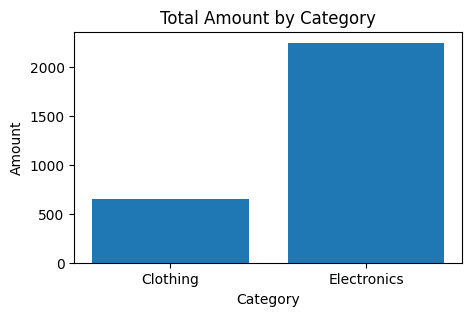

In [19]:
#Create a bar chart of category vs total amount
import matplotlib.pyplot as plt
summary = pdf.groupby("category")["amount"].sum().reset_index()
plt.figure(figsize=(5,3))
plt.bar(summary["category"], summary["amount"])
plt.title("Total Amount by Category")
plt.xlabel("Category")
plt.ylabel("Amount")
plt.show()